# PART-III: Masked Autoencoder (MAE) for Feature Learning

### Model-3: Masked Autoencoder (MAE) with CNN:

Implement a Masked Convolutional Autoencoder (MCAE):
● Mask random patches in feature maps instead of raw image patches.
● Use CNN layers for encoding masked images.
● Train on CIFAR-10 and compare with VAE.
Task:
1. Train the Masked CNN Autoencoder (MCAE) with different masking ratios.
2. Compare its performance with VAE in terms of feature extraction and reconstruction
quality.
3. Evaluate classification accuracy by using frozen embeddings from MCAE for linear
classification.
Presentation of Results:
● Compare reconstruction quality between MCAE, AE, and VAE.
● Decision region plots for classification tasks using learned embeddings.
● Heatmaps showing which parts of an image are most important for reconstruction.
● Observations on whether CNN-based masking retains global information like ViTs.

In [1]:
# ------------------ Imports and Setup ------------------

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import random

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# ------------------ CIFAR-10 DataLoader ------------------

transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

In [3]:
# ------------------ AE, VAE, and MCAE Models ------------------

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(64 * 8 * 8, 128)
        self.fc_logvar = nn.Linear(64 * 8 * 8, 128)
        self.fc_decode = nn.Linear(128, 64 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        z = self.encoder(x).view(x.size(0), -1)
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        z_sample = self.reparameterize(mu, logvar)
        z_decoded = self.fc_decode(z_sample).view(x.size(0), 64, 8, 8)
        out = self.decoder(z_decoded)
        return out, mu, logvar


class MCAE(nn.Module):
    def __init__(self):
        super(MCAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        z_masked = self.mask_features(z)
        out = self.decoder(z_masked)
        return out, z

    def mask_features(self, feature_map, ratio=0.3):
        mask = torch.rand_like(feature_map) > ratio
        return feature_map * mask

In [13]:
# ------------------ Train AE, VAE, MCAE ------------------

def train_autoencoder(model, loss_fn, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for imgs, _ in trainloader:
            imgs = imgs.to(device)
            optimizer.zero_grad()
            if isinstance(model, VAE):
                outputs, mu, logvar = model(imgs)
                recon_loss = loss_fn(outputs, imgs)
                kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / imgs.size(0)
                loss = recon_loss + kl_div
            else:
                outputs, _ = model(imgs)
                loss = loss_fn(outputs, imgs)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"{model.__class__.__name__} Epoch [{epoch+1}/10], Loss: {total_loss/len(trainloader):.4f}")

models = {
    "AE": AE().to(device),
    "VAE": VAE().to(device),
    "MCAE": MCAE().to(device)
}

optimizers = {
    name: optim.Adam(m.parameters(), lr=1e-3) for name, m in models.items()
}

criterion = nn.MSELoss()

for name in models:
    train_autoencoder(models[name], criterion, optimizers[name])

AE Epoch [1/10], Loss: 0.0109
AE Epoch [2/10], Loss: 0.0034
AE Epoch [3/10], Loss: 0.0024
AE Epoch [4/10], Loss: 0.0019
AE Epoch [5/10], Loss: 0.0016
AE Epoch [6/10], Loss: 0.0014
AE Epoch [7/10], Loss: 0.0012
AE Epoch [8/10], Loss: 0.0011
AE Epoch [9/10], Loss: 0.0010
AE Epoch [10/10], Loss: 0.0009
VAE Epoch [1/10], Loss: 0.0655
VAE Epoch [2/10], Loss: 0.0622
VAE Epoch [3/10], Loss: 0.0621
VAE Epoch [4/10], Loss: 0.0621
VAE Epoch [5/10], Loss: 0.0621
VAE Epoch [6/10], Loss: 0.0621
VAE Epoch [7/10], Loss: 0.0621
VAE Epoch [8/10], Loss: 0.0621
VAE Epoch [9/10], Loss: 0.0621
VAE Epoch [10/10], Loss: 0.0621


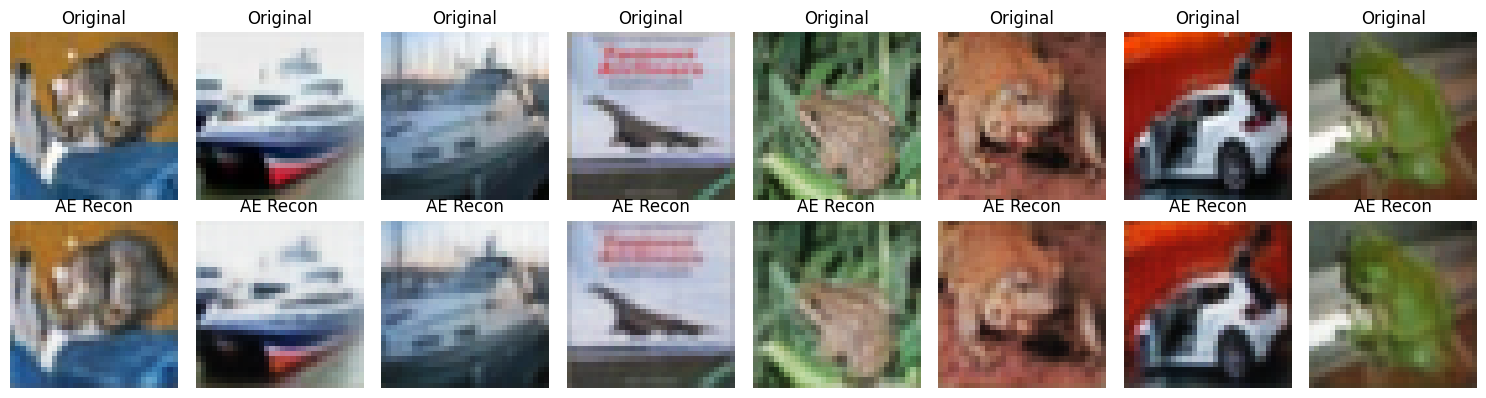

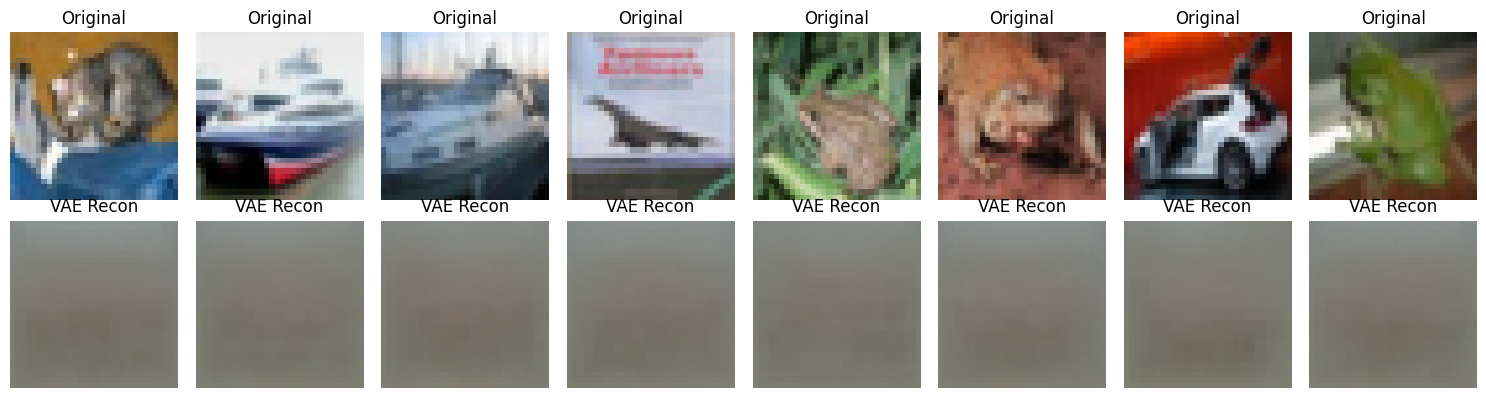

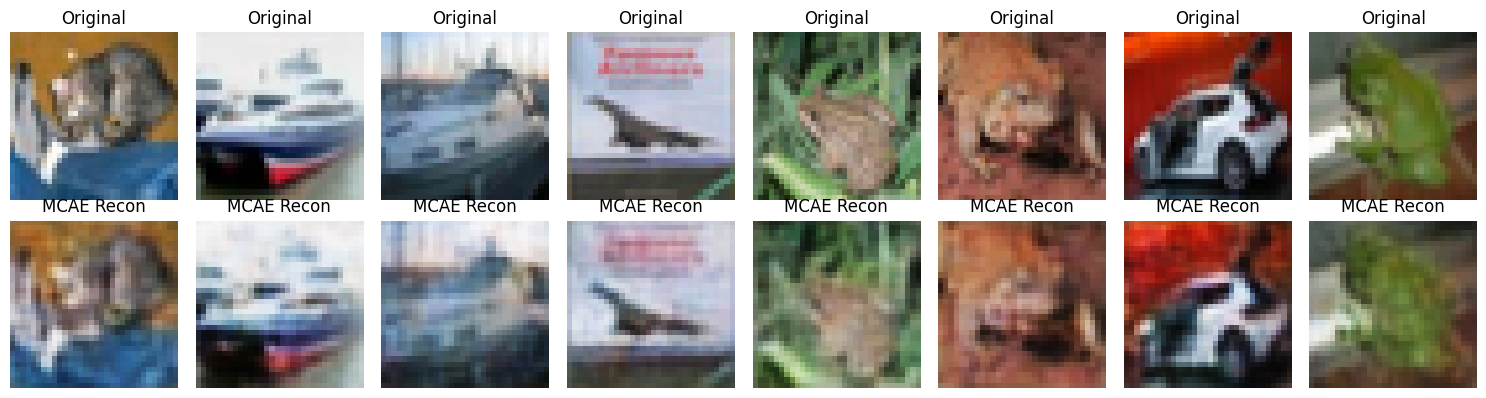

In [ ]:
# ------------------ Compare Reconstructions ------------------

def show_reconstruction(model, name):
    model.eval()
    dataiter = iter(testloader)
    images, _ = next(dataiter)
    images = images.to(device)

    with torch.no_grad():
        if isinstance(model, VAE):
            outputs, _, _ = model(images)
        else:
            outputs, _ = model(images)

    images = images.cpu()
    outputs = outputs.cpu()

    fig, axes = plt.subplots(2, 8, figsize=(15, 4))
    for i in range(8):
        axes[0, i].imshow(images[i].permute(1, 2, 0))
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')

        axes[1, i].imshow(outputs[i].permute(1, 2, 0))
        axes[1, i].axis('off')
        axes[1, i].set_title(f'{name} Recon')

    plt.tight_layout()
    plt.savefig("Compare reconstruction.png")
    plt.show()

for name, model in models.items():
    show_reconstruction(model, name)

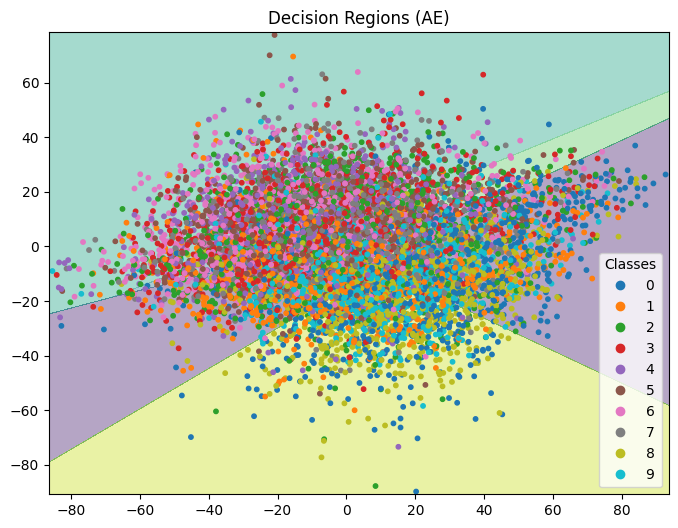

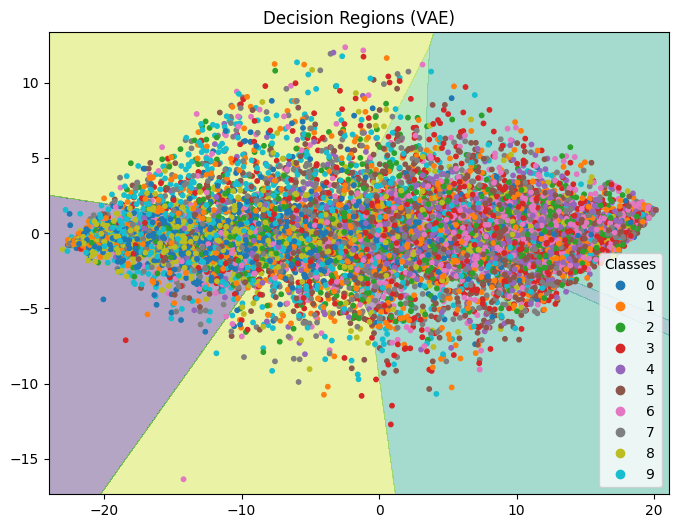

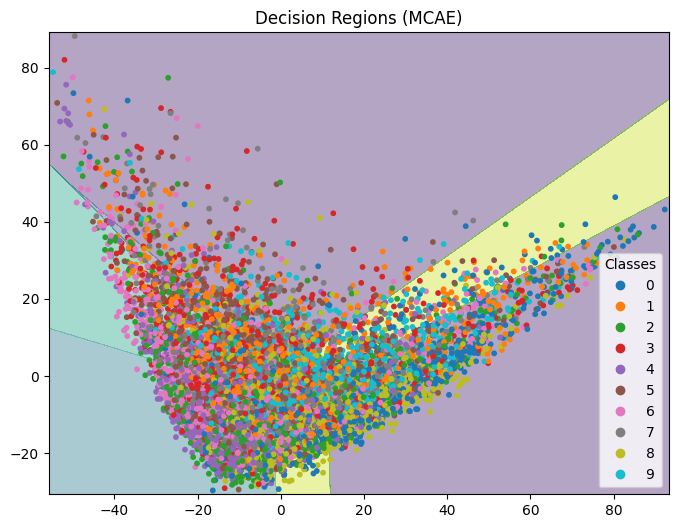

In [9]:
# ------------------ Decision Region Plot ------------------

def plot_decision_regions(model, name):
    model.eval()
    embeddings = []
    labels = []

    for imgs, lbls in testloader:
        imgs = imgs.to(device)
        with torch.no_grad():
            if isinstance(model, VAE):
                _, z, _ = model(imgs)
            else:
                _, z = model(imgs)
        embeddings.append(z.view(z.size(0), -1).cpu().numpy())
        labels.append(lbls.numpy())

    X = np.concatenate(embeddings)
    y = np.concatenate(labels)

    X = StandardScaler().fit_transform(X)
    X_pca = PCA(n_components=2).fit_transform(X)

    clf = LogisticRegression(max_iter=200)
    clf.fit(X_pca, y)
    h = .02
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.4)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=10, cmap='tab10')
    plt.title(f"Decision Regions ({name})")
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.savefig("Decision Regions.png")
    plt.show()

for name, model in models.items():
    plot_decision_regions(model, name)


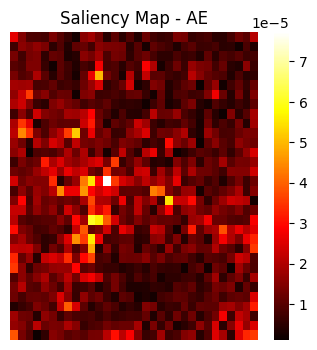

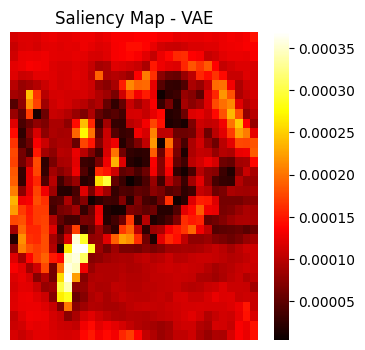

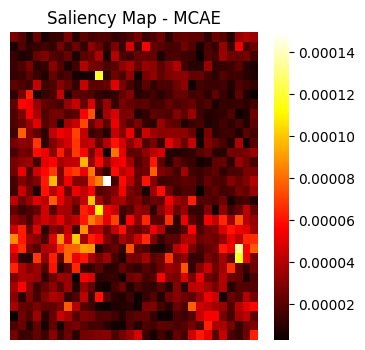

In [8]:
# ------------------ CellHeatmap for Reconstruction Importance ------------------
def compute_saliency_map(model, name):
    model.eval()
    dataiter = iter(testloader)
    images, _ = next(dataiter)
    img = images[0:1].to(device)
    img.requires_grad_()

    if isinstance(model, VAE):
        output, _, _ = model(img)
    else:
        output, _ = model(img)
    loss = criterion(output, img)
    loss.backward()
    saliency = img.grad.data.abs().squeeze().cpu()

    saliency = saliency.mean(dim=0)
    plt.figure(figsize=(4, 4))
    sns.heatmap(saliency, cmap='hot')
    plt.title(f"Saliency Map - {name}")
    plt.savefig("Heatmap od recondtractor.png")
    plt.axis('off')
    plt.show()

for name, model in models.items():
    compute_saliency_map(model, name)

